In [1]:
# The best-performing version of SVM with class weigts as balancing method, and 
# no stopword removal, stemming, unigram TF-IDF and no feature selection method.

In [2]:
import pandas as pd
import nltk as nltk
from nltk.stem.snowball import NorwegianStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import re 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Prepare Dataset

In [43]:
all_events = ''
raw_data = pd.read_csv(all_events, on_bad_lines='skip', sep=';', low_memory=False) 

seed = 13062023

In [42]:
# Retreive relevant coloumns
df = pd.DataFrame(raw_data, columns=['Hendelsesbeskrivelse', '2. HENDELSESTYPE', 'AvviksTittel'])
df.rename(columns = {'2. HENDELSESTYPE': 'Hendelsestype'}, inplace = True)

In [5]:
# Dropp Null-rows and rows with too few values or not a part of NOKUP
df.dropna(subset = ['Hendelsesbeskrivelse', 'Hendelsestype'], inplace=True)
df.drop(df[df.Hendelsestype == 'IKT-systemer'].index, inplace=True)
df.drop(df[df.Hendelsestype == 'Annet - pasientuhell'].index, inplace=True) 
df.drop(df[df.Hendelsestype == 'Nei'].index, inplace=True)

In [6]:
# combines titles with the event description for more textual information
df['HendelsesbeskrivelseAvviksTittel'] = df['Hendelsesbeskrivelse'] + ' ' + df['AvviksTittel']

In [7]:
# removes numbers and special characters
def remove_non_letters(corpus):
    corpus_without_br_tag = []
    for doc in corpus:
        # remove html tag
        document = doc.replace('.<br />', '. ')
        document = doc.replace('<br />', '. ')
        #remove all special characters and numbers
        document = re.sub('[^A-Za-zæøåÆØÅ ]+', '', document)
        corpus_without_br_tag.append(document)
    return corpus_without_br_tag

In [8]:
description_title_combined = remove_non_letters(df['HendelsesbeskrivelseAvviksTittel'].tolist())
categories = df['Hendelsestype'].tolist()

### Stemming

In [9]:
# tokenize the documents to words for stemming
def tokenize(list_of_documents):
    list_of_tokens = []
    for document in list_of_documents:
        list_of_tokens.append(word_tokenize(document))
    return list_of_tokens

In [10]:
# uses the norwegian stemmer from Snowball to stem 
def stem_words(list_of_documents):
    snow_stemmer = NorwegianStemmer()
    stemmed_documents = []
    stemmed_words = []
    for document in list_of_documents:
        for word in document:
            x = snow_stemmer.stem(word)
            if x in stemmed_words:
                continue
            else:
                stemmed_words.append(x)
        stemmed_documents.append(stemmed_words)
        stemmed_words = []
    return stemmed_documents

In [11]:
tokens = tokenize(description_title_combined)
stemmed_corpus = stem_words(tokens)

In [12]:
# detoknize the words back into documents for the Tfidf-Vectorizer
detokenizer = TreebankWordDetokenizer()

corpus = []
for i in stemmed_corpus:
    corpus.append(detokenizer.detokenize(i))

### Vectorize test/train set

In [13]:
# split into train/test set
x_train, x_test, y_train, y_test = train_test_split(corpus, categories, test_size=0.25, random_state=seed)

In [14]:
vectorizer = TfidfVectorizer()
labelEncoder = preprocessing.LabelEncoder()

In [15]:
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

y_train_vectorized = labelEncoder.fit_transform(y_train)
y_test_vectorized = labelEncoder.fit_transform(y_test)

### Train the model

In [16]:
# create model with class_weights = 'balanced' added to balance the dataset
clf = svm.SVC(decision_function_shape='ovo', class_weight='balanced')

In [17]:
clf.fit(x_train_vectorized, y_train_vectorized)

SVC(class_weight='balanced', decision_function_shape='ovo')

### Run the model

In [18]:
predictions_svm = clf.predict(x_test_vectorized)

In [37]:
# map of category names from norwegian to english for display purposes
event_type_english = {
    'Blod og blodprodukter': 'Blood and Blood Products',
    'Diagnostikk, behandling og pleie': 'Diagnostics, Treatment, and Care',
    'Dokumentasjon/ informasjon': 'Documentation and Information',
    'Infeksjon': 'Infection',
    'Labaratorietjenester': 'Labaratory Services',
    'Legemidler': 'Drugs',
    'Medisinsk utstyr': 'Medical Equipment',
    'Pasientadministrasjon/ samhandling': 'Patient Administration and Coordination',
    'Pasientatferd': 'Patient Behavior',
    'Pasientuhell og fall': 'Falls and Accidents'
}

SVM
Total Accuracy score is 0.7644531614831419
Total Recall Score is 0.6999663235197879
Total Precision Score is 0.7490744682703429
Total macro F1 Score is 0.7164708990301282 
                                         precision    recall  f1-score   support

               Blood and Blood Products       0.76      0.54      0.63        69
       Diagnostics, Treatment, and Care       0.67      0.70      0.69      2528
          Documentation and Information       0.51      0.49      0.50       810
                              Infection       0.70      0.76      0.73       116
                    Labaratory Services       0.88      0.95      0.92      1632
                                  Drugs       0.77      0.84      0.81      1364
                      Medical Equipment       0.73      0.38      0.50       226
Patient Administration and Coordination       0.72      0.71      0.72      1979
                       Patient Behavior       0.77      0.75      0.76       408
             

<Axes: >

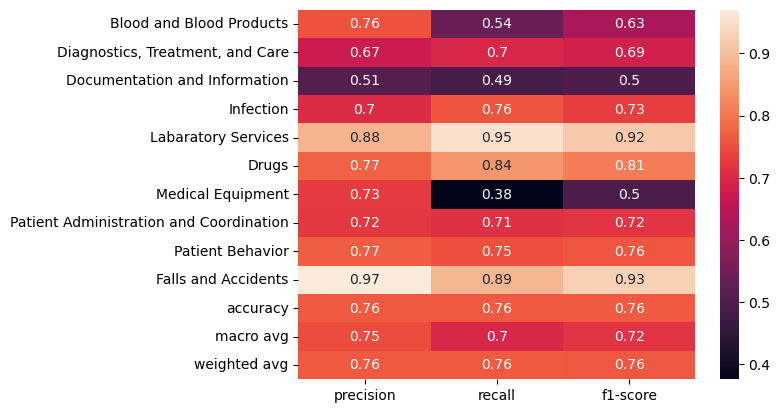

In [45]:
print("SVM")
print("Total Accuracy score is {}".format(accuracy_score(y_test_vectorized, predictions_svm)))

print("Total Recall Score is {}".format(recall_score(y_test_vectorized, predictions_svm, average="macro")))

print("Total Precision Score is {}".format(precision_score(y_test_vectorized, predictions_svm, average="macro")))

print("Total macro F1 Score is {} ".format(f1_score(y_test_vectorized, predictions_svm, average="macro")))


print(classification_report(y_test_vectorized, predictions_svm, target_names=event_type_english.values()))
clf_report = classification_report(y_test_vectorized, predictions_svm, target_names=event_type_english.values(), output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

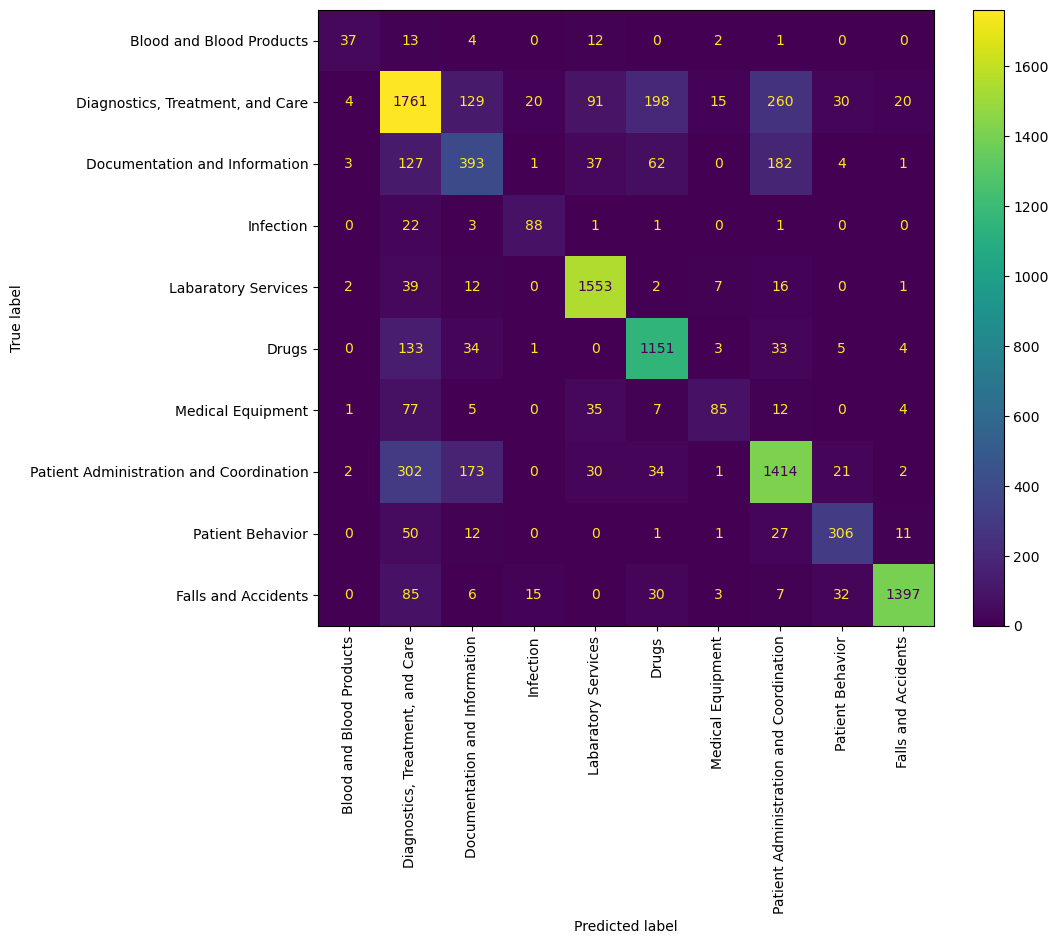

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test_vectorized, predictions_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelEncoder.inverse_transform(clf.classes_))

disp.plot(ax=ax)
ax.set_yticklabels(labels=event_type_english.values())
ax.set_xticklabels(labels=event_type_english.values(), rotation=90)

plt.show(block=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Blood and Blood Products'),
  Text(1, 0, 'Diagnostics, Treatment, and Care'),
  Text(2, 0, 'Documentation and Information'),
  Text(3, 0, 'Infection'),
  Text(4, 0, 'Labaratory Services'),
  Text(5, 0, 'Drugs'),
  Text(6, 0, 'Medical Equipment'),
  Text(7, 0, 'Patient Administration and Coordination'),
  Text(8, 0, 'Patient Behavior'),
  Text(9, 0, 'Falls and Accidents')])

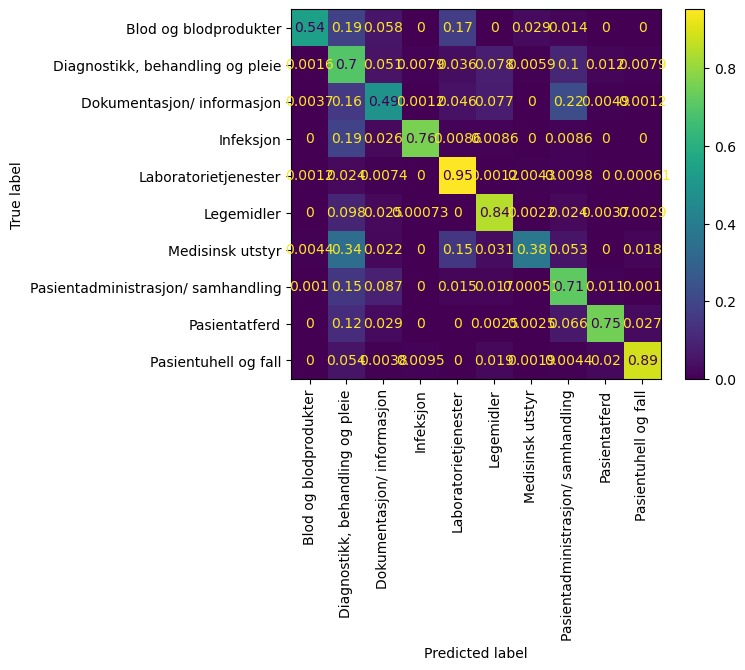

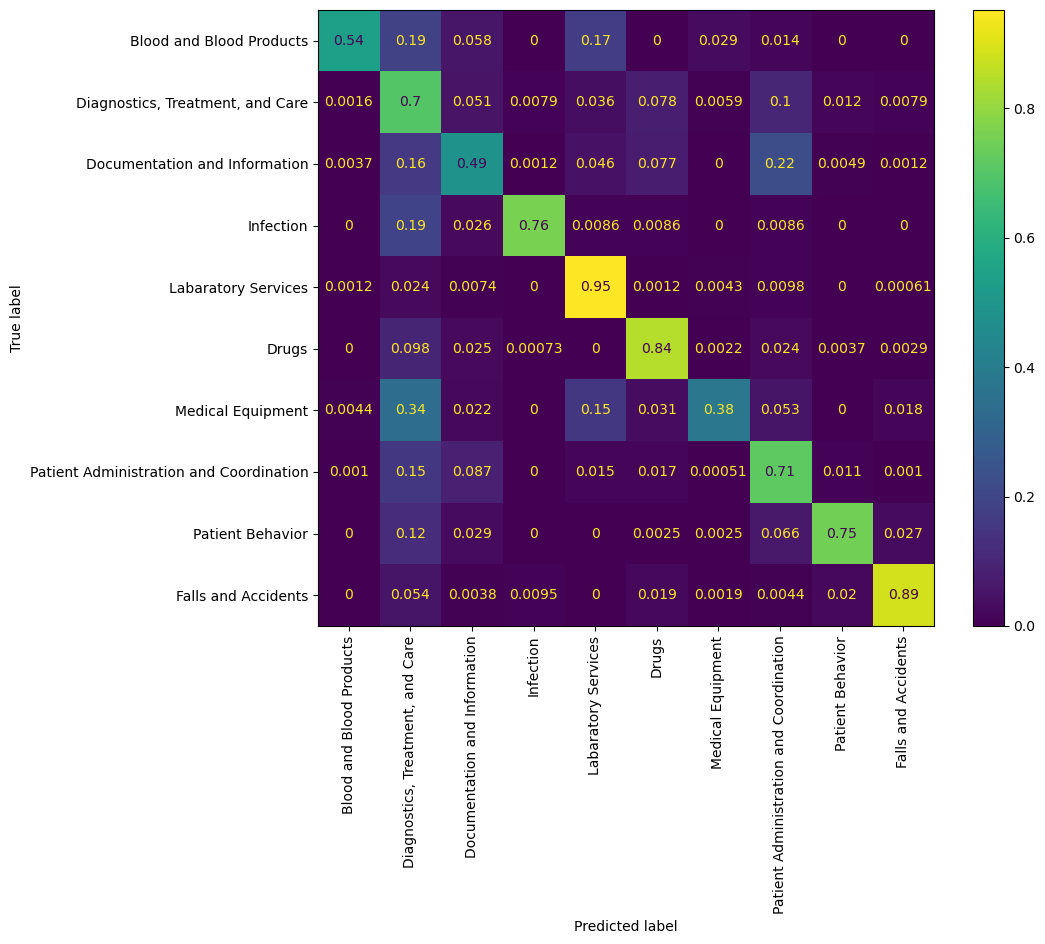

In [44]:
#normalized confusion matrix over true conditions (rows)
disp2 = ConfusionMatrixDisplay.from_predictions(y_test_vectorized, predictions_svm, normalize="true", xticks_rotation="vertical", display_labels=labelEncoder.inverse_transform(clf.classes_))

fig, ax = plt.subplots(figsize=(10,8))
disp2.plot(ax=ax)
ax.set_yticklabels(labels=event_type_english.values())
ax.set_xticklabels(labels=event_type_english.values(), rotation=90)

plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Blood and Blood Products'),
  Text(1, 0, 'Diagnostics, Treatment, and Care'),
  Text(2, 0, 'Documentation and Information'),
  Text(3, 0, 'Infection'),
  Text(4, 0, 'Labaratory Services'),
  Text(5, 0, 'Drugs'),
  Text(6, 0, 'Medical Equipment'),
  Text(7, 0, 'Patient Administration and Coordination'),
  Text(8, 0, 'Patient Behavior'),
  Text(9, 0, 'Falls and Accidents')])

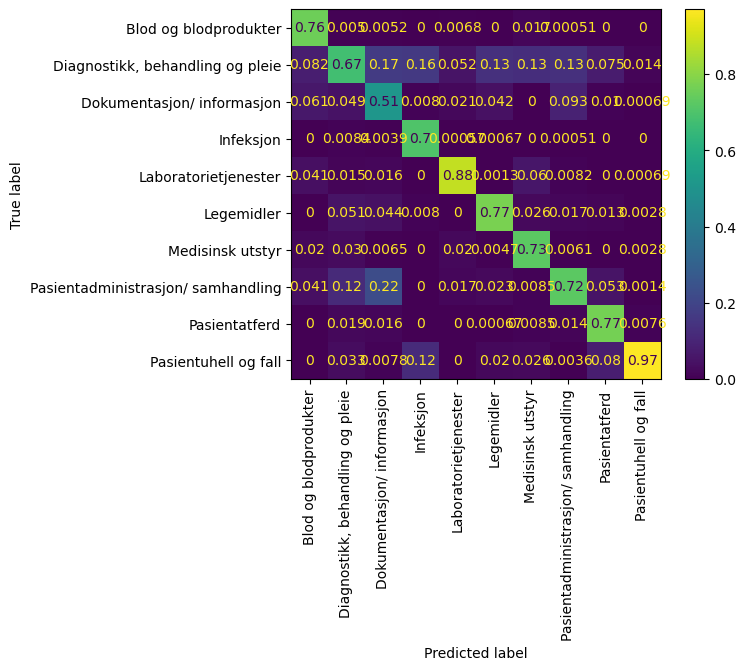

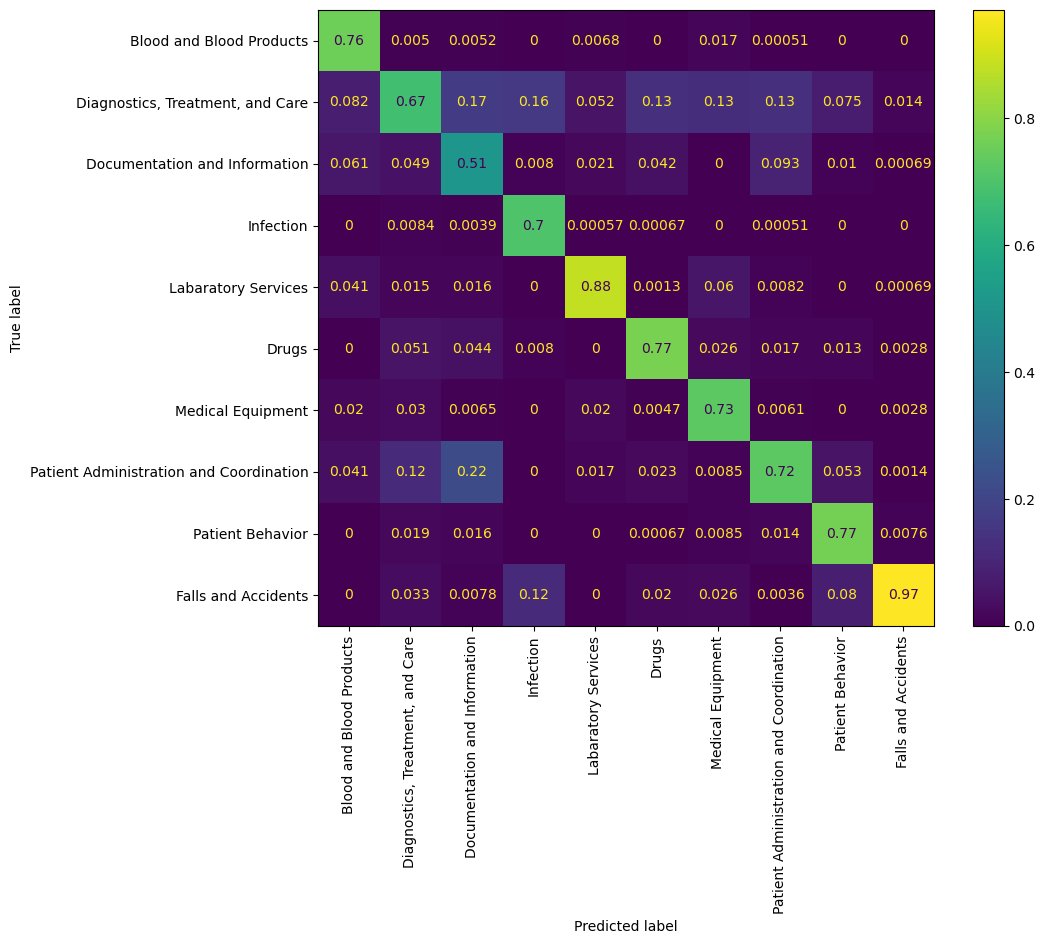

In [41]:
#normalized confusion matrix over predicted conditions (columns) 
disp2 = ConfusionMatrixDisplay.from_predictions(y_test_vectorized, predictions_svm, normalize="pred", xticks_rotation="vertical", display_labels=labelEncoder.inverse_transform(clf.classes_))
fig, ax = plt.subplots(figsize=(10,8))

disp2.plot(ax=ax)
ax.set_yticklabels(labels=event_type_english.values())
ax.set_xticklabels(labels=event_type_english.values(), rotation=90)

plt.xticks(rotation=90)